In [390]:
import importlib
import warnings

import common_func as cf
importlib.reload(cf)
warnings.filterwarnings('ignore')

In [391]:
class CommonShortStrategy(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name: str, startegy_name: str):
        self._max_depth = 4
        self._show_warn = True
        cf.TradingStrategy.__init__(self, loader, asset_name, self._max_depth, startegy_name, initial_balance=2000.0, terminate_if_bankrupt=True)

class ShortStrangle(CommonShortStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        CommonShortStrategy.__init__(self, loader, asset_name, "Short strangle")
        self.__call0 = -1
        self.__put0 = -1

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[self.__call0]['Delta'] + puts[self.__put0]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        for c in range(0, self._max_depth):
            call = calls[c]['Strike']
            for i in range(0, self._max_depth):
                put = puts[i]['Strike']
                if call > put:
                    self.__call0 = c
                    self.__put0 = i
                    return True

        if self._show_warn:
            print(f"Can't find proper call/put Short Strangle call: {calls[0]['Strike']}/{calls[1]['Strike']}/{calls[2]['Strike']}/{calls[3]['Strike']} puts: {puts[0]['Strike']}/{puts[1]['Strike']}/{puts[2]['Strike']}/{puts[3]['Strike']}")
        return False

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[self.__call0], puts[self.__put0]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortStraddle(CommonShortStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        CommonShortStrategy.__init__(self, loader, asset_name, "Short straddle")
        self.__call0 = 0
        self.__put0 = 0

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[self.__call0]['Delta'] + puts[self.__put0]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        for c in range(0, self._max_depth):
            call = calls[self.__call0]['Strike']
            for i in range(0, self._max_depth):
                put = puts[i]['Strike']
                if call == put:
                    self.__call0 = c
                    self.__put0 = i
                    return True

        if self._show_warn:
            print(f"Can't find proper call/put Short Straddle call: {calls[0]['Strike']}/{calls[1]['Strike']}/{calls[2]['Strike']}/{calls[3]['Strike']} puts: {puts[0]['Strike']}/{puts[1]['Strike']}/{puts[2]['Strike']}/{puts[3]['Strike']}")
        return False

        # return calls[0]['Strike'] == puts[0]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[self.__call0], puts[self.__put0]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortButterfly(CommonShortStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        CommonShortStrategy.__init__(self, loader, asset_name, "Short Butterfly")
        self.__call0 = 0
        self.__call1 = -1
        self.__put0 = 0
        self.__put1 = -1

    def _get_option_count(self):
        return 4

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return -calls[self.__call1]['Delta'] + calls[self.__call0]['Delta'] + puts[self.__put0]['Delta'] - puts[self.__put1]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        # call0 = calls[0]['Strike']
        # call1 = calls[1]['Strike']
        # put0 = puts[0]['Strike']
        # put1 = puts[1]['Strike']

        #print(f"{put1} < {put0} == {call0} < {call1}")
        for c in range(0, self._max_depth):
            call0 = calls[self.__call0]['Strike']
            for i in range(0, self._max_depth):
                put0 = puts[i]['Strike']
                if call0 == put0:
                    self.__call0 = c
                    self.__put0 = i

                    for j in range(1, self._max_depth):
                        call1 = calls[j]['Strike']
                        if call1 > call0:
                            self.__call1 = j
                            break

                    if self.__call1 == -1:
                        break

                    for j in range(self.__put0 + 1, self._max_depth):
                        put1 = puts[j]['Strike']
                        if put1 < put0:
                            self.__put1 = j
                            break

                    if self.__put1 == -1:
                        break

                    return True

        if self._show_warn:
            print(f"Can't find proper call/put Short Butterfly call: {calls[0]['Strike']}/{calls[1]['Strike']}/{calls[2]['Strike']}/{calls[3]['Strike']} puts: {puts[0]['Strike']}/{puts[1]['Strike']}/{puts[2]['Strike']}/{puts[3]['Strike']}")
            return False
            #return put1 < put0 and put0 == call0 and call0 < call1

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[self.__call0], puts[self.__put0]]

    def _long_portfolio(self, calls:list, puts: list):
        return [calls[self.__call1], puts[self.__put1]]

class ShortIronCondor(CommonShortStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        CommonShortStrategy.__init__(self, loader, asset_name, "Short iron condor")
        self.__call0 = 0
        self.__call1 = -1
        self.__put0 = 0
        self.__put1 = -1

    def _get_option_count(self):
        return 4

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        # return -calls[1]['Delta'] + calls[0]['Delta'] + puts[0]['Delta'] - puts[1]['Delta']
        return -calls[self.__call1]['Delta'] + calls[self.__call0]['Delta'] + puts[self.__put0]['Delta'] - puts[self.__put1]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        #call0 = calls[self.__call0]['Strike']
        for c in range(0, self._max_depth):
            call0 = calls[c]['Strike']
            for i in range(0, self._max_depth):
                put0 = puts[i]['Strike']
                if call0 > put0:
                    self.__call0 = c
                    self.__put0 = i

                    for j in range(1, self._max_depth):
                        call1 = calls[j]['Strike']
                        if call1 > call0:
                            self.__call1 = j
                            break

                    if self.__call1 == -1:
                        break

                    for j in range(self.__put0 + 1, self._max_depth):
                        put1 = puts[j]['Strike']
                        if put1 < put0:
                            self.__put1 = j
                            break

                    if self.__put1 == -1:
                        break

                    return True
        if self._show_warn:
            print(f"Can't find proper call/put Short Butterfly call: {calls[0]['Strike']}/{calls[1]['Strike']}/{calls[2]['Strike']}/{calls[3]['Strike']} puts: {puts[0]['Strike']}/{puts[1]['Strike']}/{puts[2]['Strike']}/{puts[3]['Strike']}")
        return False
        # call0 = calls[0]['Strike']
        # call1 = calls[1]['Strike']
        # put0 = puts[0]['Strike']
        # put1 = puts[1]['Strike']

        #print(f"{put1} < {put0} == {call0} < {call1}")


        # return put1 < put0 < call0 < call1

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[self.__call0], puts[self.__put0]]
        # return [calls[0], puts[0]]

    def _long_portfolio(self, calls:list, puts: list):
        return [calls[self.__call1], puts[self.__put1]]
        # return [calls[1], puts[1]]

All files for AMZN are ready. Loading
End loading in 0.5625 seconds
Simulation for AMZN
Next date 2016-11-01
Total income: 12.3, Total: 2012.3
Total pay: 0.0, Total: 2012.3
Total income: 25.549999999999997, Total: 2037.85
Total pay: 0.0, Total: 2037.85
Next date 2016-11-02
Total income: 11.3, Total: 2049.1499999999996
Total pay: 0.0, Total: 2049.1499999999996
Total income: 24.9, Total: 2074.0499999999997
Total pay: 0.0, Total: 2074.0499999999997
Next date 2016-11-03
Total income: 5.35, Total: 2079.3999999999996
Total pay: 0.0, Total: 2079.3999999999996
Total income: 24.95, Total: 2104.3499999999995
Total pay: 0.0, Total: 2104.3499999999995
Total income: 27.0, Total: 2131.3499999999995
Total pay: 0.0, Total: 2131.3499999999995
Next date 2016-11-04
From 6 expired SHORT options only 3 were executed. Total minus -42.350000000000136
Total income: 23.6, Total: 2112.599999999999
Total pay: 0.0, Total: 2112.599999999999
Total income: 29.5, Total: 2142.099999999999
Total pay: 0.0, Total: 2142.0

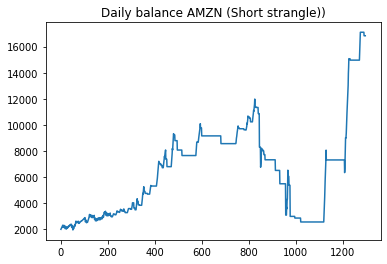

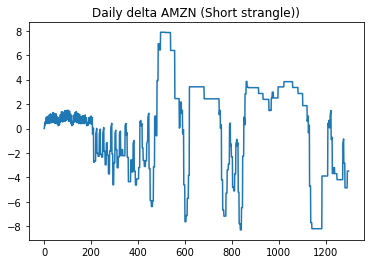

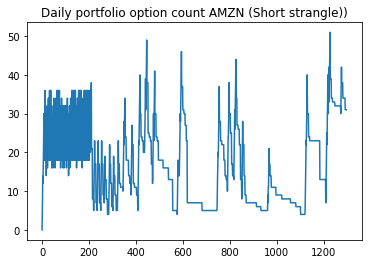

Elapsed time 6.703125 seconds
AMZN (Short strangle): winning strategy. Final balance 16829.11999999998 after 1297 days


In [392]:
#assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
assets = ['AMZN']
for asset_name in assets:
    loader = cf.DataLoader(asset_name)
    loader.load()
    print(f"Simulation for {asset_name}")

    ShortStrangle(loader, asset_name).simulate(show_plots=True, trace=True).status()
    #ShortStraddle(loader, asset_name).simulate().status()
    #ShortButterfly(loader, asset_name).simulate().status()
    #ShortIronCondor(loader, asset_name).simulate().status()

